<a href="https://colab.research.google.com/github/renaldfredy/Thesis/blob/main/Recurrent%20Approach/MHA_CNN_LSTM_Trial_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MHA-CNN1D-LSTM

In [ ]:
project_name = 'MHA_CNN1D_LSTM'
Timelag = 12

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install -q -U keras-tuner

In [ ]:
pip install attention -q

In [ ]:
pip install keras-multi-head -q

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import LSTM, SimpleRNN, Bidirectional, GRU, Conv1D
from tensorflow.keras.layers import Dropout, Embedding, TimeDistributed, MaxPooling1D
from tensorflow.keras.metrics import RootMeanSquaredError
from keras.initializers import RandomNormal
from keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras.layers import Conv1D, MaxPooling2D
from keras import Model
from keras.layers import Layer
import keras.backend as K
from keras.models import model_from_json
# from keras_tuner.tuners import RandomSearch, BayesianOptimization
# from keras_tuner.engine.hyperparameters import HyperParameters
import warnings
import pickle
warnings.filterwarnings("ignore")

In [ ]:
seed_value= 42

# Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)

# Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)
np.random.seed(42)

# Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

print(tf.random.uniform([42]).numpy())

[0.6645621  0.44100678 0.3528825  0.46448255 0.03366041 0.68467236
 0.74011743 0.8724445  0.22632635 0.22319686 0.3103881  0.7223358
 0.13318717 0.5480639  0.5746088  0.8996835  0.00946367 0.5212307
 0.6345445  0.1993283  0.72942245 0.54583454 0.10756552 0.6767061
 0.6602763  0.33695042 0.60141766 0.21062577 0.8527372  0.44062173
 0.9485276  0.23752594 0.81179297 0.5263394  0.494308   0.21612847
 0.8457197  0.8718841  0.3083862  0.6868038  0.23764038 0.7817228 ]


In [ ]:
# trying open dataset

pickle_in_tr_0 =open("/content/drive/MyDrive/Renald/Preprosessing_data/Data_Train_0_3D.pickle",'rb')
Xtrain_0 = pickle.load(pickle_in_tr_0)

pickle_in_val_0 =open("/content/drive/MyDrive/Renald/Preprosessing_data/Data_Val_0_3D.pickle",'rb')
Xval_0 = pickle.load(pickle_in_val_0)

pickle_in_ts_0 =open("/content/drive/MyDrive/Renald/Preprosessing_data/Data_Test_0_3D.pickle",'rb')
Xtest_0 = pickle.load(pickle_in_ts_0)

# print(Xtrain_0)
print(Xtrain_0.shape)
print(Xval_0.shape)
print(Xtest_0.shape)

(288, 779, 9)
(96, 779, 9)
(96, 779, 9)


In [ ]:
Xtrain_0_transpose = np.transpose(Xtrain_0, (1, 0, 2))
Xval_0_transpose = np.transpose(Xval_0, (1, 0, 2))
Xtest_0_transpose = np.transpose(Xtest_0, (1, 0, 2))
Xtrain_0_transpose.shape

(779, 288, 9)

In [ ]:
all_data = np.hstack((Xtrain_0_transpose,Xval_0_transpose,Xtest_0_transpose))

all_data.shape

(779, 480, 9)

In [ ]:
pd.DataFrame(all_data[0]).head(15)

,0,1,2,3,4,5,6,7,8
0,467.086792,450.509216,450.493469,463.481934,463.987152,463.586304,464.221161,454.073120,455.535645
1,329.553650,332.110718,325.165436,323.138031,323.946747,319.100983,314.429291,315.854004,303.505096
2,191.304688,194.310349,203.168213,202.327225,205.625854,213.830566,176.942657,181.324371,209.248688
3,256.511261,251.699554,267.314087,243.805115,245.511902,236.010803,235.431396,237.056396,260.986267
4,279.643127,282.230225,272.270935,316.828491,316.661316,316.682556,312.520203,317.095947,324.420502
5,307.906799,317.287048,322.728668,324.538788,340.247498,299.962311,269.737976,280.043182,255.843201
6,276.002838,271.639465,270.517883,289.815277,285.368927,280.642517,289.259216,286.155457,247.657745
7,158.347504,155.264359,145.810822,139.594055,136.844742,130.358826,115.160339,112.121460,99.258423
8,438.333496,444.230103,408.436035,418.862854,424.856354,378.957397,385.197113,391.942841,348.880249
9,409.619232,397.067383,398.271423,350.422211,341.599182,389.730804,325.846466,318.161255,357.823364


#Visualizing Target

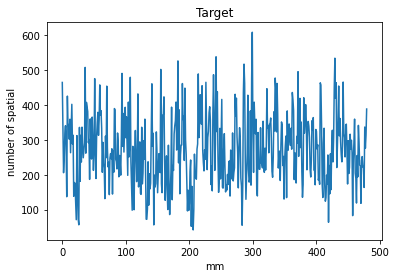

In [ ]:
# load dataset
dataset = all_data[0].copy()
values = dataset
# specify columns to plot
groups = [4]
i = 1
# plot each column
plt.figure()
for group in groups:
  plt.subplot(len(groups), 1, i)
  plt.plot(values[:, group])
  plt.title('Target')
  plt.xlabel('mm')
  plt.ylabel('number of spatial')
  i += 1
plt.show()

In [ ]:

Target = all_data[:,:,[4]].reshape(779,480,1)
Target.shape

(779, 480, 1)

In [ ]:
d = all_data[:,:-1,:]
T = Target[:,1:,:]
merging_data = np.dstack((d, T))
merging_data.shape

(779, 479, 10)

In [ ]:
j = all_data[:,:-1,:]
k = Target[:,1:,:]
merge_data = np.dstack((d, T))
merge_data.shape

(779, 479, 10)

In [ ]:
merge = pd.DataFrame(merge_data[0]).drop(4,axis=1)
np.shape(merge)

(479, 9)

In [ ]:
merge

,0,1,2,3,5,6,7,8,9
0,467.086792,450.509216,450.493469,463.481934,463.586304,464.221161,454.073120,455.535645,323.946747
1,329.553650,332.110718,325.165436,323.138031,319.100983,314.429291,315.854004,303.505096,205.625854
2,191.304688,194.310349,203.168213,202.327225,213.830566,176.942657,181.324371,209.248688,245.511902
3,256.511261,251.699554,267.314087,243.805115,236.010803,235.431396,237.056396,260.986267,316.661316
4,279.643127,282.230225,272.270935,316.828491,316.682556,312.520203,317.095947,324.420502,340.247498
...,...,...,...,...,...,...,...,...,...
474,215.362259,220.084747,220.066437,221.347260,220.921188,225.244095,228.886383,219.776276,163.409225
475,178.041290,168.478027,162.583588,165.195450,161.273102,150.200577,147.437241,130.647644,336.403229
476,326.390259,326.232483,323.531799,330.739868,317.736694,316.792603,323.693359,306.447693,275.805267
477,284.119263,282.079559,265.485229,282.309448,264.850494,281.646545,280.248901,254.388306,313.046967


In [ ]:
co = merge.corr()
co[9]

0    0.347344
1    0.347265
2    0.344629
3    0.340643
5    0.335638
6    0.329338
7    0.330668
8    0.322523
9    1.000000
Name: 9, dtype: float64

In [ ]:
corelation = pd.DataFrame(all_data[0]).corr()
corelation[4]

0    0.985935
1    0.987058
2    0.983753
3    0.996816
4    1.000000
5    0.990686
6    0.982669
7    0.987019
8    0.973987
Name: 4, dtype: float64

In [ ]:
corrMatrix = pd.DataFrame(merging_data[0]).corr()
corrMatrix[9]

0    0.347344
1    0.347265
2    0.344629
3    0.340643
4    0.340190
5    0.335638
6    0.329338
7    0.330668
8    0.322523
9    1.000000
Name: 9, dtype: float64

In [ ]:
np.argwhere(np.isnan(all_data))

array([], shape=(0, 3), dtype=int64)

In [ ]:
np.shape(all_data)

(779, 480, 9)

In [ ]:
df1 = pd.DataFrame(all_data[0])
df_ =df1[0].iloc[1:]

df_

1      329.553650
2      191.304688
3      256.511261
4      279.643127
5      307.906799
          ...    
475    178.041290
476    326.390259
477    284.119263
478    321.845520
479    399.726624
Name: 0, Length: 479, dtype: float64

In [ ]:
# assigning a new variable
# df2 = df1.copy().drop(columns='Target', axis=1)
df2 = []

for h in range(len(all_data)):
  df1 = pd.DataFrame(all_data[h])
  # df_ =df1.iloc[1:]
  df2.append(df1)

In [ ]:
np.shape(df2)

(779, 480, 9)

In [ ]:
type(df2[0])

pandas.core.frame.DataFrame

In [ ]:
past_month = Timelag

def TimeLagTransform(data, past_month):
  cols = data.columns
  for i in reversed(range(past_month)):
    for j in cols:
      data['%s(t-%d)'%(j,i+1)] = data[j].shift(periods=i)
  return data



In [ ]:
# calling function

df2_all = []
for i in range(len(all_data)):
  df3 = TimeLagTransform(data=df2[i].copy(), past_month=past_month).drop(columns=df2[i].columns, axis=1).dropna()
  df4 = df3.iloc[:-1]
  df2_all.append(df4)

In [ ]:
df2_all[0]

,0(t-12),1(t-12),2(t-12),3(t-12),4(t-12),5(t-12),6(t-12),7(t-12),8(t-12),0(t-11),...,8(t-2),0(t-1),1(t-1),2(t-1),3(t-1),4(t-1),5(t-1),6(t-1),7(t-1),8(t-1)
11,467.086792,450.509216,450.493469,463.481934,463.987152,463.586304,464.221161,454.073120,455.535645,329.553650,...,339.820374,301.535706,292.578583,303.917816,299.749207,301.513489,312.693787,289.492920,282.004944,286.224670
12,329.553650,332.110718,325.165436,323.138031,323.946747,319.100983,314.429291,315.854004,303.505096,191.304688,...,286.224670,355.790009,342.387360,347.182312,373.976685,358.759521,354.760132,416.243347,396.517090,433.099274
13,191.304688,194.310349,203.168213,202.327225,205.625854,213.830566,176.942657,181.324371,209.248688,256.511261,...,433.099274,275.548248,277.775208,273.088562,261.197693,262.917816,280.585144,260.060547,263.377502,239.457077
14,256.511261,251.699554,267.314087,243.805115,245.511902,236.010803,235.431396,237.056396,260.986267,279.643127,...,239.457077,326.940582,329.795227,329.939301,328.907806,330.073700,323.615295,334.714844,336.267761,316.371735
15,279.643127,282.230225,272.270935,316.828491,316.661316,316.682556,312.520203,317.095947,324.420502,307.906799,...,316.371735,436.349182,428.748260,448.847565,397.710999,401.394165,448.389465,434.760437,439.022705,486.146729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,135.717133,126.127258,126.429482,118.929840,118.850075,115.907265,109.592224,109.402756,100.114601,250.363647,...,227.918427,215.362259,220.084747,220.066437,221.347260,223.238129,220.921188,225.244095,228.886383,219.776276
475,250.363647,260.808624,235.540710,255.817947,254.871185,257.008331,243.025879,249.374527,254.348053,200.156586,...,219.776276,178.041290,168.478027,162.583588,165.195450,163.409225,161.273102,150.200577,147.437241,130.647644
476,200.156586,198.505005,187.546982,196.690765,193.657593,182.953918,194.678925,190.160553,175.391434,355.850922,...,130.647644,326.390259,326.232483,323.531799,330.739868,336.403229,317.736694,316.792603,323.693359,306.447693
477,355.850922,345.981964,340.183258,350.101624,341.115417,340.635010,363.458679,345.540588,339.475342,299.799713,...,306.447693,284.119263,282.079559,265.485229,282.309448,275.805267,264.850494,281.646545,280.248901,254.388306


In [ ]:
pd.DataFrame(Target[0]).head(15)

,0
0,463.987152
1,323.946747
2,205.625854
3,245.511902
4,316.661316
5,340.247498
6,285.368927
7,136.844742
8,424.856354
9,341.599182


#Splitting Data

##Dealing with Input Data


In [ ]:
# converting into numpy array
X_train = []
X_val = []
X_test = []

for l in range(len(all_data)):
  values = df2_all[l].values
  panjang = len(df2_all[0])
  # splitting train-val-test
  train = values[:round(3/5*panjang),:]
  val = values[round(3/5*panjang):round(4/5*panjang),:]
  test = values[round(4/5*panjang):,:]
  X_train.append(train)
  X_val.append(val)
  X_test.append(test)




In [ ]:
print(np.shape(X_train))
print(np.shape(X_val))
print(np.shape(X_test))

(779, 281, 108)
(779, 93, 108)
(779, 94, 108)


##Dealing with Target Data

In [ ]:
# delete 11 row
new_target = []

for n in range(len(all_data)):
  df_target = pd.DataFrame(Target[n].copy())
  df_target1 = df_target.iloc[(past_month):]
  new_target.append(df_target1)


In [ ]:
new_target[0]

,0
12,358.759521
13,262.917816
14,330.073700
15,401.394165
16,287.891388
...,...
475,163.409225
476,336.403229
477,275.805267
478,313.046967


In [ ]:
np.shape(new_target)

(779, 468, 1)

In [ ]:
y_train = []
y_val = []
y_test = []

for l in range(len(all_data)):
  values = new_target[l].values
  panjang = len(new_target[0])
  # splitting train-val-test
  ytrain = values[:round(3/5*panjang),:].reshape(round(3/5*panjang))
  yval = values[round(3/5*panjang):round(4/5*panjang),:].reshape((round(4/5*panjang))-(round(3/5*panjang)))
  ytest = values[round(4/5*panjang):,:].reshape(panjang-(round(4/5*panjang)))
  y_train.append(ytrain)
  y_val.append(yval)
  y_test.append(ytest)

In [ ]:
print(np.shape(y_train))
print(np.shape(y_val))
print(np.shape(y_test))

(779, 281)
(779, 93)
(779, 94)


#Normalization

In [ ]:
# calling function into a variable
scaler = StandardScaler()
# applying normalization
xtrain_norm = []
xval_norm = []
xtest_norm = []

for o in range(len(all_data)):
  xtrain, xval, xtest = scaler.fit_transform(X_train[o]), scaler.transform(X_val[o]), scaler.transform(X_test[o])
  xtrain_norm.append(xtrain)
  xval_norm.append(xval)
  xtest_norm.append(xtest)

# assigning values into dataframe
df_xtrain = pd.DataFrame(data=xtrain, columns=df2_all[0].columns)
df_xval = pd.DataFrame(data=xval, columns=df2_all[0].columns)
df_xtest = pd.DataFrame(data=xtest, columns=df2_all[0].columns)

df_xtrain

,0(t-12),1(t-12),2(t-12),3(t-12),4(t-12),5(t-12),6(t-12),7(t-12),8(t-12),0(t-11),...,8(t-2),0(t-1),1(t-1),2(t-1),3(t-1),4(t-1),5(t-1),6(t-1),7(t-1),8(t-1)
0,0.298165,0.322646,0.331771,0.338140,0.337732,0.347445,0.363705,0.347189,0.357144,0.043430,...,0.196887,1.323682,1.343967,1.378598,1.443200,1.390715,1.417105,1.428862,1.369619,1.393996
1,0.039226,0.033592,0.041289,0.052442,0.036296,0.046585,0.058288,0.054111,0.049516,-0.274976,...,1.392056,0.565034,0.638696,0.627018,0.572969,0.651605,0.644258,0.721577,0.614753,0.606606
2,-0.279584,-0.232328,-0.268081,-0.436062,-0.427041,-0.460539,-0.491852,-0.577187,-0.601293,0.941696,...,0.604397,2.353427,2.127907,2.087896,2.207866,2.109935,2.058602,1.916759,1.961530,1.923987
3,0.938632,0.632493,0.607055,0.550756,0.483279,0.447956,0.250384,0.413908,0.411716,0.362270,...,1.922228,1.072676,0.986762,1.025808,1.032257,0.926592,0.951237,1.048744,1.013963,1.017232
4,0.358471,0.798565,0.767570,0.311700,0.648771,0.624697,0.039083,0.186180,0.155393,0.438790,...,1.015162,1.300280,1.406630,1.393957,1.317678,1.472537,1.443292,1.106390,0.825353,0.839136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,0.963097,0.966413,0.922765,0.946349,0.945156,0.918630,0.877306,0.881356,0.892658,0.630894,...,-0.274584,0.729187,0.741824,0.686471,0.710244,0.725234,0.667274,0.668233,0.649748,0.620688
277,0.627436,0.623642,0.648426,0.620943,0.659500,0.671010,0.613936,0.604250,0.617025,1.880691,...,0.618484,0.705041,0.726329,0.729258,0.739239,0.740695,0.731836,0.748763,0.695825,0.743230
278,1.878819,1.692462,1.551120,1.835444,1.671108,1.554379,1.654862,1.699883,1.600084,0.944248,...,0.741068,0.270199,0.275269,0.315588,0.288293,0.276068,0.305934,0.281033,0.295875,0.320222
279,0.941187,1.033068,1.035331,0.834537,0.892438,0.937351,0.706698,0.724357,0.789976,0.125291,...,0.317915,0.504535,0.314952,0.256607,0.553729,0.501138,0.375004,0.507422,0.464754,0.315520


In [ ]:
print(np.shape(xtrain_norm))
print(np.shape(xval_norm))
print(np.shape(xtest_norm))

(779, 281, 108)
(779, 93, 108)
(779, 94, 108)


#Adjusting Dimension

In [ ]:
# reshaping data

xtrain_adjust_3D = []
xval_adjust_3D = []
xtest_adjust_3D = []

for p in range(len(all_data)):
  xtrain_adjust = xtrain_norm[0].reshape((xtrain_norm[0].shape[0],past_month,int(xtrain_norm[0].shape[1]/past_month)))
  xtrain_adjust_3D.append(xtrain_adjust)

  xval_adjust = xval_norm[0].reshape((xval_norm[0].shape[0],past_month,int(xval_norm[0].shape[1]/past_month)))
  xval_adjust_3D.append(xval_adjust)

  xtest_adjust = xtest_norm[0].reshape((xtest_norm[0].shape[0],past_month,int(xtest_norm[0].shape[1]/past_month)))
  xtest_adjust_3D.append(xtest_adjust)

# printing result
print('x:', xtrain_adjust_3D[0].shape, xval_adjust_3D[0].shape, xtest_adjust_3D[0].shape)
print('y:', y_train[0].shape, y_val[0].shape, y_test[0].shape)

x: (281, 12, 9) (93, 12, 9) (94, 12, 9)
y: (281,) (93,) (94,)


In [ ]:
type(y_train[0])

numpy.ndarray

#Model

In [ ]:
n_input = past_month
n_features = int(xtrain_norm[0].shape[1]/past_month)
n_output = 1

In [ ]:
# class attention_layer(Layer):
#     def __init__(self,**kwargs):
#         super(attention_layer,self).__init__(**kwargs)
 
#     def build(self,input_shape):
#         self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1), 
#                                initializer='random_normal', trainable=True)
#         self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1), 
#                                initializer='zeros', trainable=True)        
#         super(attention_layer, self).build(input_shape)
 
#     def call(self,x):
#         # Alignment scores. Pass them through tanh function
#         e = K.tanh(K.dot(x,self.W)+self.b)
#         # Remove dimension of size 1
#         e = K.squeeze(e, axis=-1)   
#         # Compute the weights
#         alpha = K.softmax(e)
#         # Reshape to tensorFlow format
#         alpha = K.expand_dims(alpha, axis=-1)
#         # Compute the context vector
#         context = x * alpha
#         context = K.sum(context, axis=1)
#         return context
    


In [ ]:
# from keras_self_attention import SeqSelfAttention
from keras.layers import Flatten
from attention import Attention
from keras_multi_head import MultiHeadAttention

model = Sequential()
model.add(Input(shape=((n_input, n_features))))
model.add(MultiHeadAttention(head_num=3))
model.add(Conv1D(filters=32, kernel_size=1, activation='relu'))
model.add(MaxPooling1D(pool_size=1))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(Attention(32))
model.add(Dense(n_output, activation=keras.layers.LeakyReLU(alpha=0.01)))
model.compile(loss='mean_absolute_error', optimizer='Adam',
              metrics = ["mean_absolute_percentage_error", RootMeanSquaredError()])

# def build_model(hp):
#     model = Sequential()
#     # hp_units = hp.Int('units', min_value=32, max_value=500, step=1)
#     # model.add(LSTM(units=hp_units, input_shape=(n_input, n_features), return_sequences=True))
#     # model.add(TimeDistributed(Flatten(input_shape=(779,))))

#     model.add(keras.Input(shape=(n_input, n_features)))
#     model.add(MultiHeadAttention(head_num=3))
#     model.add(Bidirectional(LSTM(hp.Int('input_unit',min_value=32,max_value=128,step=1),return_sequences=True)))
#     # model.add(Dropout(0.2))
#     for i in range(hp.Int('n_layers', 1, 2)):
#         model.add(Bidirectional(LSTM(hp.Int(f'lstm_{i}_units',min_value=32,max_value=128,step=1),return_sequences=True)))
#     # model.add(LSTM(hp.Int('layer_2_neurons',min_value=32,max_value=512,step=1), return_sequences=True))
#     # model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
#     # model.add(SeqSelfAttention(attention_activation='sigmoid'))
#     # model.add(Flatten())
#     model.add(Attention(hp.Int('input_unit',min_value=32,max_value=128,step=1)))
#     model.add(Dense(n_output, activation=hp.Choice('dense_activation',values=['LeakyReLU'],default='LeakyReLU')))
#     model.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)),metrics = ["mean_absolute_percentage_error",RootMeanSquaredError()])
#     return model

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 multi_head_attention (Multi  (None, 12, 9)            360       
 HeadAttention)                                                  
                                                                 
 conv1d (Conv1D)             (None, 12, 32)            320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 12, 32)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 12, 32)            8320      
                                                                 
 lstm_1 (LSTM)               (None, 12, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 12, 32)            8

In [ ]:
history_all = []
for q in range(0,779):
  print('index: ',q)
  LSTM_history = model.fit(xtrain_adjust_3D[q], y_train[q],epochs=1, batch_size=32,validation_data=(xval_adjust_3D[q], y_val[q]), 
             verbose=2, shuffle=False)
  history_all.append(LSTM_history)

index:  0
9/9 - 9s - loss: 265.1089 - mean_absolute_percentage_error: 99.8635 - root_mean_squared_error: 284.9034 - val_loss: 295.6962 - val_mean_absolute_percentage_error: 99.6932 - val_root_mean_squared_error: 309.8250 - 9s/epoch - 980ms/step
index:  1
9/9 - 0s - loss: 259.1720 - mean_absolute_percentage_error: 99.0294 - root_mean_squared_error: 278.7696 - val_loss: 290.3071 - val_mean_absolute_percentage_error: 98.6242 - val_root_mean_squared_error: 304.1971 - 138ms/epoch - 15ms/step
index:  2
9/9 - 0s - loss: 243.9742 - mean_absolute_percentage_error: 97.5640 - root_mean_squared_error: 263.6413 - val_loss: 274.6743 - val_mean_absolute_percentage_error: 97.6662 - val_root_mean_squared_error: 288.2368 - 134ms/epoch - 15ms/step
index:  3
9/9 - 0s - loss: 239.4841 - mean_absolute_percentage_error: 96.7745 - root_mean_squared_error: 258.6062 - val_loss: 271.8645 - val_mean_absolute_percentage_error: 97.2640 - val_root_mean_squared_error: 284.4538 - 134ms/epoch - 15ms/step
index:  4
9/9 

In [ ]:
def plot_loss(history, title):
    history_loss = []
    history_val_loss = []
    for m in range (0,779):
      h_loss = history[m].history['loss']
      history_loss.append(h_loss)
      h_val_loss = history[m].history['val_loss']
      history_val_loss.append(h_val_loss)

    
    history_loss_array = np.array(history_loss)
    history_loss_all = history_loss_array.flatten()
    history_val_loss_array = np.array(history_val_loss)
    history_val_loss_all= history_val_loss_array.flatten()

    plt.figure(figsize=(10,6))
    plt.plot(history_loss_all, label='Train')
    plt.plot(history_val_loss_all, label='Validation')
    plt.title(title)
    plt.xlabel('Number of Spatial')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    loss = history_loss_all
    min_idx = np.argmin(loss)
    min_loss = loss[min_idx]
    print('Minimum loss of {} reached at epoch {}'.format(min_loss, min_idx))

    max_idx = np.argmax(loss)
    max_loss = loss[max_idx]
    print('Maximum loss of {} reached at epoch {}'.format(max_loss, max_idx))

    mean_idx_training = np.mean(loss)
    # mean_val_metrics = val_metrics[mean_idx]
    print('Average training loss: ', mean_idx_training)
    
    val_loss = history_val_loss_all
    min_idx = np.argmin(val_loss)
    min_val_loss = val_loss[min_idx]
    print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))

    max_idx = np.argmax(val_loss)
    max_val_loss = val_loss[max_idx]
    print('Maximum validation loss of {} reached at epoch {}'.format(max_val_loss, max_idx))

    val_loss = history_val_loss_all
    mean_idx = np.mean(val_loss)
    # mean_val_loss = val_loss[mean_idx]
    print('Average validation loss: ',mean_idx)

def plot_metrics_mape(history, title):

    history_metrics = []
    history_val_metrics = []
    for m in range (0,779):
      h_metrics = history[m].history['mean_absolute_percentage_error']
      # h_metrics = history[m].history['root_mean_squared_error']
      history_metrics.append(h_metrics)
      h_val_metrics = history[m].history['val_mean_absolute_percentage_error']
      # h_val_metrics = history[m].history['val_root_mean_squared_error']
      history_val_metrics.append(h_val_metrics)

    
    history_metrics_array = np.array(history_metrics)
    history_metrics_all = history_metrics_array.flatten()
    history_val_metrics_array = np.array(history_val_metrics)
    history_val_metrics_all= history_val_metrics_array.flatten()

    plt.figure(figsize=(10,6))
    plt.plot(history_metrics_all, label='Train')
    plt.plot(history_val_metrics_all, label='Validation')
    plt.title(title)
    plt.xlabel('Number of Spatial')
    plt.ylabel('MAPE')
    plt.legend()
    plt.show()
    
    metrics = history_metrics_all
    min_idx = np.argmin(metrics)
    min_metrics = metrics[min_idx]
    print('Minimum MAPE of {} reached at epoch {}'.format(min_metrics, min_idx))

    max_idx = np.argmax(metrics)
    max_metrics = metrics[max_idx]
    print('Maximum MAPE of {} reached at epoch {}'.format(max_metrics, max_idx))

    mean_idx_training = np.mean(metrics)
    # mean_val_metrics = val_metrics[mean_idx]
    print('Average training MAPE: ', mean_idx_training)
    
    val_metrics = history_val_metrics_all
    min_idx = np.argmin(val_metrics)
    min_val_metrics = val_metrics[min_idx]
    print('Minimum validation MAPE of {} reached at epoch {}'.format(min_val_metrics, min_idx))

    max_idx = np.argmax(val_metrics)
    max_val_metrics = val_metrics[max_idx]
    print('Maximum validation MAPE of {} reached at epoch {}'.format(max_val_metrics, max_idx))

    val_metrics = history_val_metrics_all
    mean_idx = np.mean(val_metrics)
    # mean_val_metrics = val_metrics[min_idx]
    print('Average validation MAPE: ',mean_idx)

def plot_metrics_rmse(history, title):

    history_metrics = []
    history_val_metrics = []
    for m in range (0,779):
      # h_metrics = history[m].history['mean_absolute_error']
      h_metrics = history[m].history['root_mean_squared_error']
      history_metrics.append(h_metrics)
      # h_val_metrics = history[m].history['val_mean_absolute_error']
      h_val_metrics = history[m].history['val_root_mean_squared_error']
      history_val_metrics.append(h_val_metrics)

    
    history_metrics_array = np.array(history_metrics)
    history_metrics_all = history_metrics_array.flatten()
    history_val_metrics_array = np.array(history_val_metrics)
    history_val_metrics_all= history_val_metrics_array.flatten()

    plt.figure(figsize=(10,6))
    plt.plot(history_metrics_all, label='Train')
    plt.plot(history_val_metrics_all, label='Validation')
    plt.title(title)
    plt.xlabel('Number of Spatial')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()
    
    metrics = history_metrics_all
    min_idx = np.argmin(metrics)
    min_metrics = metrics[min_idx]
    print('Minimum RMSE of {} reached at epoch {}'.format(min_metrics, min_idx))

    max_idx = np.argmax(metrics)
    max_metrics = metrics[max_idx]
    print('Maximum RMSE of {} reached at epoch {}'.format(max_metrics, max_idx))

    mean_idx_training = np.mean(metrics)
    # mean_val_metrics = val_metrics[mean_idx]
    print('Average training RMSE: ', mean_idx_training)
    
    val_metrics = history_val_metrics_all
    min_idx = np.argmin(val_metrics)
    min_val_metrics = val_metrics[min_idx]
    print('Minimum validation RMSE of {} reached at epoch {}'.format(min_val_metrics, min_idx))

    max_idx = np.argmax(val_metrics)
    max_val_metrics = val_metrics[max_idx]
    print('Maximum validation RMSE of {} reached at epoch {}'.format(max_val_metrics, max_idx))

    val_metrics = history_val_metrics_all
    mean_idx = np.mean(val_metrics)
    # mean_val_metrics = val_metrics[mean_idx]
    print('Average validation RMSE: ', mean_idx)



# van_lstm_hist[0].history['loss']


# # plt.plot(hist[0].history)
# hist_l = np.array(hist_loss)
# his_l_ = hist_l.flatten()
# hist_val_loss = np.array(hist_val_loss)
# hist_v = hist_val_loss.flatten()
# # plt.plot(hist)
# plt.plot(his_l_, label = 'train')
# plt.plot(hist_v, label = 'val')

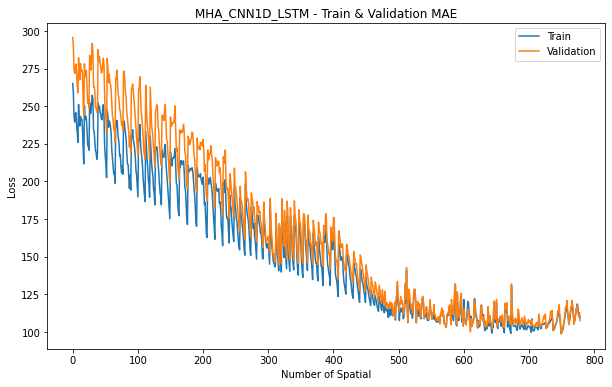

Minimum loss of 99.09596252441406 reached at epoch 672
Maximum loss of 265.1089172363281 reached at epoch 0
Average training loss:  153.99260546154173
Minimum validation loss of 98.69532012939453 reached at epoch 749
Maximum validation loss of 295.6961975097656 reached at epoch 0
Average validation loss:  165.40901717845833


In [ ]:
plot_loss(history_all, f'{project_name} - Train & Validation MAE')

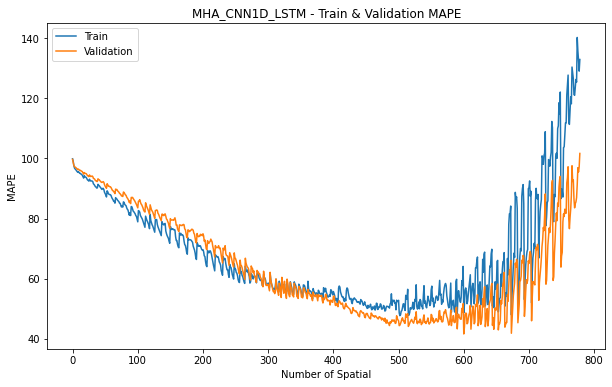

Minimum MAPE of 47.672813415527344 reached at epoch 502
Maximum MAPE of 140.25164794921875 reached at epoch 774
Average training MAPE:  68.05612634112808
Minimum validation MAPE of 41.57258605957031 reached at epoch 600
Maximum validation MAPE of 101.65403747558594 reached at epoch 778
Average validation MAPE:  64.06792018043214


In [ ]:
plot_metrics_mape(history_all, f'{project_name} - Train & Validation MAPE')

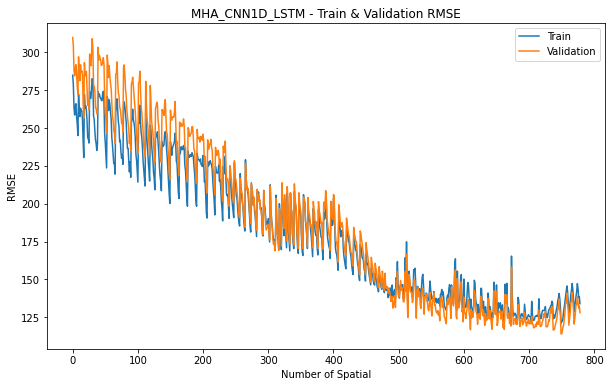

Minimum RMSE of 121.00779724121094 reached at epoch 749
Maximum RMSE of 284.90338134765625 reached at epoch 0
Average training RMSE:  181.15903567900554
Minimum validation RMSE of 113.94915771484375 reached at epoch 749
Maximum validation RMSE of 309.8249816894531 reached at epoch 0
Average validation RMSE:  186.071803747919


In [ ]:
plot_metrics_rmse(history_all, f'{project_name} - Train & Validation RMSE')

In [ ]:
evaluation = []
for s in range (0,779):
  evaluated_LSTM = model.evaluate(xtest_adjust_3D[s], y_test[s])
  evaluation.append(evaluated_LSTM)

In [ ]:

# evaluation.shape

evaluation_array = np.array(evaluation)
# evaluation_flatten= evaluation_array.flatten()
evaluation_array.shape
eva = np.hsplit(evaluation_array,3)
eva[0]

plt.figure(figsize=(10,6))
plt.plot(eva[0], label='Loss')
# plt.plot(len(eva[0]), label='Performance')
plt.title('Model Evaluated - Loss')
plt.xlabel('Number of Spatial')
plt.ylabel('Loss')
plt.legend()
plt.show()
print('minimum Loss: ', np.min(eva[0]))
print('maximum Loss: ', np.max(eva[0]))
print('minimum Loss at epoch: ',np.argmin(eva[0]))
print('average: ', np.mean(eva[0]))

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(eva[1], label='Performance', color='green')
# plt.plot(len(eva[0]), label='Performance')
plt.title('Model Evaluated - Performance - MAPE')
plt.xlabel('Number of Spatial')
plt.ylabel('Loss Performance')
plt.legend()
plt.show()
print('minimum MAPE: ', np.min(eva[1]))
print('maximum MAPE: ', np.max(eva[1]))
print('minimum MAPE at epoch: ',np.argmin(eva[1]))
print('average: ', np.mean(eva[1]))

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(eva[2], label='Performance', color='green')
# plt.plot(len(eva[0]), label='Performance')
plt.title('Model Evaluated - Performance - RMSE')
plt.xlabel('Number of Spatial')
plt.ylabel('Loss Performance')
plt.legend()
plt.show()
print('minimum RMSE: ', np.min(eva[2]))
print('maximum RMSE: ', np.max(eva[2]))
print('minimum RMSE at epoch: ',np.argmin(eva[2]))
print('average: ', np.mean(eva[2]))

#Saving Model

In [ ]:
model.save(f'/content/drive/MyDrive/Renald/Project Manual/save_model/{project_name}.h5')

#Load Model

In [ ]:
from tensorflow.keras.models import load_model
 
# load model
new_model = load_model(f'/content/drive/MyDrive/Renald/Project Manual/save_model/{project_name}.h5', 
                       custom_objects={'Attention': Attention})
# summarize model.
model.summary()

# from keras.utils import CustomObjectScope

# with CustomObjectScope({'AttentionLayer': Attention}):
#     model = load_model(f'/content/drive/MyDrive/Renald/Project Manual/save_model/{project_name}.h5')

In [ ]:
new_history_all = []
for q in range(0,779):
  print('index: ',q)
  LSTM_history = new_model.fit(xtrain_adjust_3D[q], y_train[q],epochs=1, batch_size=32,validation_data=(xval_adjust_3D[q], y_val[q]), 
             verbose=2, shuffle=False)
  new_history_all.append(LSTM_history)

In [ ]:
plot_loss(new_history_all, f'{project_name} - Train & Validation MAE')

In [ ]:
plot_metrics_mape(new_history_all, f'{project_name} - Train & Validation MAPE')

In [ ]:
plot_metrics_rmse(new_history_all, f'{project_name} - Train & Validation RMSE')

In [ ]:
new_evaluation = []
for s in range (0,779):
  evaluated_LSTM = new_model.evaluate(xtest_adjust_3D[s], y_test[s])
  new_evaluation.append(evaluated_LSTM)

In [ ]:

# evaluation.shape

evaluation_array = np.array(new_evaluation)
# evaluation_flatten= evaluation_array.flatten()
evaluation_array.shape
eva = np.hsplit(evaluation_array,3)
eva[0]

plt.figure(figsize=(10,6))
plt.plot(eva[0], label='Loss')
# plt.plot(len(eva[0]), label='Performance')
plt.title('Model Evaluated - Loss')
plt.xlabel('Number of Spatial')
plt.ylabel('Loss')
plt.legend()
plt.show()
print('minimum Loss: ', np.min(eva[0]))
print('maximum Loss: ', np.max(eva[0]))
print('minimum Loss at epoch: ',np.argmin(eva[0]))
print('average: ', np.mean(eva[0]))

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(eva[1], label='Performance', color='green')
# plt.plot(len(eva[0]), label='Performance')
plt.title('Model Evaluated - Performance - MAPE')
plt.xlabel('Number of Spatial')
plt.ylabel('Loss Performance')
plt.legend()
plt.show()
print('minimum MAPE: ', np.min(eva[1]))
print('maximum MAPE: ', np.max(eva[1]))
print('minimum MAPE at epoch: ',np.argmin(eva[1]))
print('average: ', np.mean(eva[1]))

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(eva[2], label='Performance', color='green')
# plt.plot(len(eva[0]), label='Performance')
plt.title('Model Evaluated - Performance - RMSE')
plt.xlabel('Number of Spatial')
plt.ylabel('Loss Performance')
plt.legend()
plt.show()
print('minimum RMSE: ', np.min(eva[2]))
print('maximum RMSE: ', np.max(eva[2]))
print('minimum RMSE at epoch: ',np.argmin(eva[2]))
print('average: ', np.mean(eva[2]))